In [1]:
from cycada_utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'On {device}')

Figure directory exists.
On cuda:0


1. took batch norm out of D_T/D_S discriminators (paper supports this)
2. Edit GANLoss 

<b> 3. Better separate GAN Loss between generator and discriminator </b>

In [2]:
class CyDataset(Dataset):
    def __init__(self):

        self.D = []
        self.L = []
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_labeled.pkl', "rb") as fp:
            for station in pkl.load(fp):
#                 if station['PM25'] <600:
                self.D.append(tuple((station['Image'][:,:,:3], station['PM25'])))
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Lucknow.pkl', "rb") as fp:
            for station in pkl.load(fp):
                for datapoint in station:
                    luck_img = datapoint['Image'][:,:,:3]
                    if luck_img.shape == (224, 224,3):  
                        self.L.append(tuple((luck_img, datapoint['PM'])))
                        
        self.L = random.choices(self.L, k= len(self.D))
        
    def __len__(self): return (len(self.D))
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor()])

        d_img = self.D[idx][0]
        d_img = transform(d_img)        
        l_img = self.L[idx][0]
        l_img = transform(l_img)
        
        sample = {
              'D img': d_img,
              'D pm' : torch.tensor(self.D[idx][1]),
              'L img': l_img,
              'L pm' : torch.tensor(self.L[idx][1])
        }
        return sample

In [3]:
tr = CyDataset()
train, val = train_test_split(tr, test_size=0.2, random_state=42)
train_dataloader = DataLoader(
    train,
    batch_size=5, # 1
    shuffle=True)

val_dataloader = DataLoader(
    val,
    batch_size=1, # 1
    shuffle=True)

# Updated discriminator

In [4]:
import functools
import torch.nn as nn

class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if norm_layer is not None:
            if type(norm_layer) == functools.partial:
                use_bias = norm_layer.func == nn.InstanceNorm2d
            else:
                use_bias = norm_layer == nn.InstanceNorm2d
        else:
            use_bias = True

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                    nn.LeakyReLU(0.2, True)]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult) if norm_layer is not None else nn.Identity(),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult) if norm_layer is not None else nn.Identity(),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
#         sequence += [nn.Softmax(dim=1)] 
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


In [14]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):

        super(GANLoss, self).__init__()
        
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        
        self.gan_mode = gan_mode
        
        if self.gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
            
        elif self.gan_mode == 'wgangp':
            self.loss = None
            
    def get_target_tensor(self, prediction, target_is_real):
        
        if target_is_real:
            target_tensor = self.real_label
            
        else:
            target_tensor = self.fake_label
        
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        
        if self.gan_mode == 'vanilla':
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
            
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
                
        return loss
    
#         # Calculate discriminator accuracy
#         pred_labels = torch.round(torch.sigmoid(prediction)).squeeze()
#         true_labels = torch.ones_like(pred_labels) if target_is_real else torch.zeros_like(pred_labels)
        
#         correct_predictions = torch.sum(pred_labels == true_labels).item()
#         total_predictions = true_labels.numel()  
        
#         accuracy = correct_predictions / total_predictions
        
#         return loss, accuracy
    

In [15]:
def prediction(out, target=None, onehot=True):
    if target is None :
        _, label = torch.max(out.data, 1)
        return label
    else:
        if onehot:
            _, label = torch.max(out.data, 1)
        else: #if output is a one channel, set a label where threshold is 0.5
            label = torch.where(out.data>torch.FloatTensor([0.5]), torch.ones(out.size()[0]).long(), torch.zeros(out.size()[0]).long())
        acc = (label == target).sum().item() / target.size()[0]
        return label, acc

In [16]:
def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028

    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( | |gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss

    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            alpha = alpha.to(device)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None


In [26]:
norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
G_ST = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_TS = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)

D_T = NLayerDiscriminator(input_nc=3, ndf=64, n_layers=3, norm_layer=None)

D_S = NLayerDiscriminator(input_nc=3, ndf=64, n_layers=3, norm_layer=None)
f_s = Multi_City_CNN()
f_s.load_state_dict(torch.load('dlm4.pt'))

G_ST.to(device)
G_TS.to(device)
D_S.to(device)
D_T.to(device)
f_s.to(device)


ganloss = GANLoss(gan_mode='vanilla').to(device)       #use to fool discriminator
cycleloss = torch.nn.L1Loss().to(device)               #difference between reconstructed img and original
mseloss = torch.nn.MSELoss().to(device)       #difference between domain classifications between input img and generator output

optimizer_G = torch.optim.Adam(itertools.chain(G_ST.parameters(), G_TS.parameters()), lr=2e-4, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_S.parameters(), D_T.parameters()), lr=1e-5, betas=(0.5, 0.999))
optimizer_f_s = torch.optim.Adam(f_s.parameters(), lr=1e-4, betas=(0.5, 0.999))    


G_ST.apply(weights_init_normal)
G_TS.apply(weights_init_normal)
D_S.apply(weights_init_normal)
D_T.apply(weights_init_normal)
print()

In [25]:
def Disc_Loss(netD, real, fake, gan_mode):
    """Calculate GAN loss for the discriminator

    Parameters:
        netD (network)      -- the discriminator D
        real (tensor array) -- real images
        fake (tensor array) -- images generated by a generator

    Return the discriminator loss.
    We also call loss_D.backward() to calculate the gradients.
    """
    # Real
    pred_real = netD(real)
    loss_D_real = GANLoss(pred_real, True)
    # Fake
    pred_fake = netD(fake.detach())
    loss_D_fake = GANLoss(pred_fake, False)
    # Combined loss and calculate gradients

    print(loss_D_real, loss_D_fake)
    if gan_mode == "wgangp":
        gradient_penalty, gradients = cal_gradient_penalty(netD,real,fake,device)
        gradient_penalty.backward(retain_graph=True)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
    else:
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        
    # Calculate discriminator accuracy
    true_labels = torch.ones(real.size()[0]).long()
    fake_labels = torch.zeros(fake.detach().size()[0]).long()
    _, true_acc = prediction(pred_real.squeeze().cpu(), true_labels, onehot=False)
    _, fake_acc = prediction(pred_fake.squeeze().cpu(), fake_labels, onehot=False)
    acc = (true_acc + fake_acc) * 0.5
    return loss_D, acc

In [27]:
def sample_images(dataloader, e, i, save=False):

    source = next(iter(dataloader))
    G_ST.eval()
    G_TS.eval()
    real_source = source['D img'].type(Tensor) 
    fake_target = G_ST(real_source).detach()
    real_target = source['L img'].type(Tensor)
    real_lbl= source['D pm'].type(Tensor).float()
    fake_source = G_TS(real_target).detach()
    
    recons = G_TS(fake_target).detach()
    recont = G_ST(fake_source).detach() 

    real_S = make_grid(real_source, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_T = make_grid(fake_target, nrow=5, normalize=True, scale_each=True, padding=1)
    reconS = make_grid(recons, nrow=5, normalize=True, scale_each=True, padding=1)
    real_T = make_grid(real_target, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_S = make_grid(fake_source, nrow=5, normalize=True, scale_each=True, padding=1)
    reconT = make_grid(recont, nrow=5, normalize=True, scale_each=True, padding=1)
    # Arange images along y-axis    
    image_grid = torch.cat((real_S, fake_T, real_T, fake_S, reconS, reconT), 2)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real Source vs Fake Target vs Recon Source | Real Target vs Fake Source vs Recon Target')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 6)
    if save:
        plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
    plt.show();

In [28]:
history = {'epoch':[],'G_loss': [], 'D_loss':[], 'cycloss':[],'semloss':[], 'batch':[]}

num_classes = 2
best_gen_loss = 1e6
best_disc_loss = 1e6
n_epochs = 2

for e in range(n_epochs):
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        real_S = batch['D img'].type(Tensor)
        real_T = batch['L img'].type(Tensor)
        real_lbl = batch['D pm'].type(Tensor).float()
          
        #Generator Forward Pass
        G_ST.train()
        G_TS.train()
        
        fake_t         = G_ST(real_S)             #source domain img, styled as target
        fake_s         = G_TS(real_T)             #target domain img, styled as source
        
        recov_s        = G_TS(fake_t)
        recov_t        = G_ST(fake_s)
          
# ---------------------------------------------------------------------------------------------------------
# Run Regressor f_s  L_SEM = Ltask + Ltask;
# ---------------------------------------------------------------------------------------------------------
        set_requires_grad([f_s],requires_grad=False)
        optimizer_f_s.zero_grad()
    
        #Run real img and stylistically transformed img through pretrained network, need 4 instances
        pm_from_real_S  = f_s(real_S).squeeze(1)
        pm_from_fake_T  = f_s(fake_t.detach()).squeeze(1)
        
        pm_from_real_T  = f_s(real_T).squeeze(1)
        pm_from_fake_S  = f_s(fake_s.detach()).squeeze(1)

        #compute MSE from PM values ***predicted*** from real image and fake image (same pm vals tho!!)
        #DO NOT ASSESS WITH REAL PM LABEL, BUT WITH PREDICTION
        
        sem_loss_source    = mseloss(pm_from_real_S, pm_from_fake_T)  #Ltask(fs, G_TS(T), p(fs, T))                   
        sem_loss_targ      = mseloss(pm_from_real_T,pm_from_fake_S)   #Ltask(fs, G_ST(S), p(fs, S))
        sem_loss           = (sem_loss_source + sem_loss_targ)/2
        
#         sem_loss.backward()
        optimizer_f_s.step()
        
# -------------------------------------------------------------------------------------------------------
# Train Generators G_ST and G_TS L_CYC;
# -------------------------------------------------------------------------------------------------------
        set_requires_grad([D_S, D_T],requires_grad=False)
        set_requires_grad([G_ST, G_TS],requires_grad=True)
        optimizer_G.zero_grad()
    
        #****train Generator to produce convincing results to fool D****
        #extra ganloss run not included in objective......
        
        loss_GAN_S = ganloss(D_S(fake_t), True)  #L(D_S(G_ST(S)))             
        loss_GAN_T= ganloss(D_T(fake_s), True)  #L(D_T(G_TS(T)))               
        
        # cycle loss (L1 Loss)      
        loss_cycle_S   = cycleloss(recov_s, real_S)    # Lcyc(G_TS(G_ST(S)), S)
        loss_cycle_T   = cycleloss(recov_t, real_T)    # Lcyc(G_ST(G_TS(T)), T)
        loss_cycle     = loss_cycle_S + loss_cycle_T
        
        
        loss_G = loss_GAN_S + loss_GAN_T + loss_cycle
        
        print(f'loss G: {loss_G}')       
        loss_G.backward()
        optimizer_G.step()
        
# -------------------------------------------------------------------------------------------------------
# Train Discriminator S and Discriminator T L_GAN, L_GAN;
# -------------------------------------------------------------------------------------------------------
        set_requires_grad([D_S, D_T],requires_grad=True)
        optimizer_D.zero_grad()
        
        loss_real_s, _ = Disc_Loss(D_S, real_S, fake_s.detach(), 'vanilla')               
#         loss_fake_s, _ = ganloss(D_S(fake_s.detach()), False)   
        
#         loss_D_S       = (loss_real_s + loss_fake_s)
        
#         loss_real_t, _ = ganloss(D_T(real_T), True)              
#         loss_fake_t, _ = ganloss(D_T(fake_t.detach()), False)  
        
#         loss_D_T       = (loss_real_t + loss_fake_t)
#         loss_D         = (loss_D_S + loss_D_T)

#         print(f'loss D: {loss_D}')
#         loss_D.backward()
#         optimizer_D.step()
        
# # -----------------------------------------------------------------------------------------------------------
# # Train Feature Dsicriminator D_ft L_GAN;
# # -----------------------------------------------------------------------------------------------------------
#         if loss_D < best_disc_loss:
#             best_disc_loss = loss_D
#             torch.save({ 'D_S': D_S.state_dict(),'D_T': D_T.state_dict()}, 'best_discs.pt')
 
            
#         if loss_G < best_gen_loss:
#             best_gen_loss = loss_G
#             torch.save({ 'G_ST': G_ST.state_dict(),'G_TS': G_TS.state_dict()}, 'best_gens.pt')
# # ---------------------------------Visualization and Saving---------------------------------      
        
#         if (i+1) % 2500 == 0:
#             with torch.no_grad():
#                 sample_images(val_dataloader,e,i,save=False)
#                 history['G_loss'].append(loss_G.item())
#                 history['D_loss'].append(loss_D.item())
#                 history['semloss'].append(sem_loss.item())
#                 history['cycloss'].append(loss_cycle.item())
#                 history['batch'].append(i+1)
#                 history['epoch'].append(e+1)


#     now = datetime.datetime.now()
#     print(f"Epoch {e + 1}/{n_epochs} finished at {now.time()}\n\
#     [G Loss: {loss_G.item()}]\t[D Loss: {loss_D.item()}]\t[Cycle Loss: {loss_cycle.item()}]")

loss G: 2.6224093437194824
GANLoss() GANLoss()



TypeError: unsupported operand type(s) for +: 'GANLoss' and 'GANLoss'

In [12]:
df = pd.DataFrame(history)
df.to_csv('history.csv', index=False)


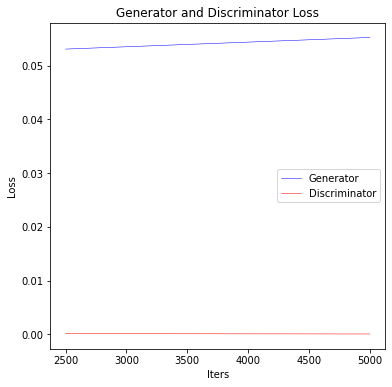

In [15]:
norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
generator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/best_gens.pt')
discriminator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/best_discs.pt')

#G's and D's will be pre loaded and set grad to false

G_ST = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_ST.load_state_dict(generator_checkpoint['G_ST'])

G_TS = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_TS.load_state_dict(generator_checkpoint['G_TS'])

D_T = NLayerDiscriminator(3)
D_T.load_state_dict(discriminator_checkpoint['D_T'])

D_S = NLayerDiscriminator(3)
D_S.load_state_dict(discriminator_checkpoint['D_S'])

D_ft = FeatureDiscriminator()

f_s = Multi_City_CNN()
f_s.load_state_dict(torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/saved_models/dlm4.pt'))

f_t = LeNet(3)
# f_t = Multi_City_CNN()
# f_t.load_state_dict(torch.load('dlm4.pt'))

G_ST.to(device)
G_TS.to(device)
D_S.to(device)
D_T.to(device)
D_ft.to(device)
f_s.to(device)
f_t.to(device)

ganloss = GANLoss().to(device)                         #use to fool discriminator
cycleloss = torch.nn.L1Loss().to(device)               #difference between reconstructed img and original
ftloss = torch.nn.modules.CrossEntropyLoss().to(device)            #difference between generator output from input img and input img
mseloss = torch.nn.MSELoss().to(device)       #difference between domain classifications between input img and generator output

optimizer_G = torch.optim.Adam(itertools.chain(G_ST.parameters(), G_TS.parameters()), lr=2e-4, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_S.parameters(), D_T.parameters()), lr=1e-5, betas=(0.5, 0.999))
optimizer_f_s = torch.optim.Adam(f_s.parameters(), lr=1e-4, betas=(0.5, 0.999))  

optimizer_f_t = torch.optim.Adam(f_t.parameters(), lr=1e-5, betas=(0.5, 0.999))    #different learning rate??
optimizer_D_ft = torch.optim.Adam(D_ft.parameters(), lr=1e-5, betas=(0.5, 0.999))


D_ft.apply(weights_init_normal)
f_t.apply(weights_init_normal)

print()